In [1]:
# This enables auto-reloading of modules
%load_ext autoreload
%autoreload 2

# Import the model
from iris.src.chat_model.model import model

INFO:iris.src.chat_model.model_settings:Using environment: local
INFO:iris.src.chat_model.model_settings:Using API base URL: https://api.openai.com/v1


In [2]:
# Define conversation for testing
conversation = {
    "messages": [
        {"role": "system", "content": "You are a helpful assistant specialized in accounting."},
        {"role": "user", "content": "summarize the internal capm document"}
    ]
}

# You can modify the conversation above to test different scenarios

In [3]:
# Call the model function with our conversation and debug mode enabled
result_generator = model(conversation, debug_mode=True)

# Collect all response chunks and debug data
response_chunks = []
debug_data = None
process_monitor_output = None

for chunk in result_generator:
    # Check if this is legacy debug data 
    if chunk.startswith("\n\nDEBUG_DATA:"):
        debug_data_json = chunk.replace("\n\nDEBUG_DATA:", "")
        import json
        debug_data = json.loads(debug_data_json)
    # Check if this is process monitor output (more structured output between horizontal rules)
    elif chunk.startswith("\n\n---\n## Process Monitoring Summary"):
        process_monitor_output = chunk
    else:
        response_chunks.append(chunk)
        print(chunk, end="", flush=True)

INFO:iris.src.chat_model.model_settings:Using large model: gpt-4o-2024-08-06 in local environment
INFO:iris.src.chat_model.model_settings:Using large model: gpt-4o-2024-08-06 in local environment
INFO:iris.src.chat_model.model_settings:Using small model: gpt-4o-mini-2024-07-18 in local environment
INFO:iris.src.chat_model.model_settings:Using small model: gpt-4o-mini-2024-07-18 in local environment
2025-04-07 18:31:13,016 - root - INFO - Logging system initialized
2025-04-07 18:31:13,017 - root - INFO - Initializing model setup (sync core)...
2025-04-07 18:31:13,017 - iris.src.initial_setup.ssl.ssl - INFO - SSL certificate setup skipped in local environment
2025-04-07 18:31:13,017 - iris.src.initial_setup.oauth.oauth - INFO - Using API key authentication from local settings
2025-04-07 18:31:13,017 - iris.src.initial_setup.oauth.oauth - INFO - Using OpenAI API key from settings: sk-proj...
2025-04-07 18:31:13,017 - root - INFO - Processing input conversation...
2025-04-07 18:31:13,018 -

---
# 📋 Research Plan

## Research Statement
Research the contents and key points of the Corporate Accounting Policy Manuals (CAPM) document. Focus on summarizing the main policies and procedures outlined in the document, noting any significant differences between IFRS and US GAAP as flagged within the manual. Ensure to highlight any specific RBC terms or policy areas that are emphasized in the CAPM. This request is for a detailed content analysis, not just a list of document titles or sections.

Searching the following databases: Corporate Accounting Policy Manuals.

---


2025-04-07 18:31:19,851 - root - INFO - Displayed simplified research plan.
2025-04-07 18:31:19,852 - root - INFO - Starting 2 database queries concurrently...
2025-04-07 18:31:19,853 - iris.src.chat_model.model - INFO - Thread executing query 1/2 for database: internal_capm
2025-04-07 18:31:19,853 - iris.src.chat_model.model - INFO - Thread executing query 2/2 for database: internal_capm
2025-04-07 18:31:19,853 - root - INFO - Submitted 2 queries to thread pool.
2025-04-07 18:31:19,854 - iris.src.agents.database_subagents.database_router - INFO - Routing query (sync) to database: internal_capm with scope: research
2025-04-07 18:31:19,854 - iris.src.agents.database_subagents.database_router - INFO - Routing query (sync) to database: internal_capm with scope: research
2025-04-07 18:31:19,862 - iris.src.agents.database_subagents.internal_capm.subagent - INFO - Querying Internal CAPM database: 'Summarize main policies and procedures in CAPM, noting IFRS vs US GAAP differences.' with scope



---
**Database:** Corporate Accounting Policy Manuals
**Query:** `Highlight specific RBC terms and emphasized policy areas in CAPM.`
**Status:** 📄 Documents sections found, but they do not contain relevant information for this query.
---

2025-04-07 18:31:28,038 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-07 18:31:28,041 - iris.src.llm_connectors.rbc_openai - INFO - Received response in 6.68 seconds
2025-04-07 18:31:28,042 - iris.src.llm_connectors.rbc_openai - INFO - Token usage - Completion: 556 ($0.0000), Prompt: 2181 ($0.0000), Total: 2737 tokens, Total Cost: $0.0000 (Database: internal_capm)
2025-04-07 18:31:28,043 - iris.src.agents.database_subagents.internal_capm.subagent - INFO - Successfully parsed synthesis tool call for internal_capm.
2025-04-07 18:31:28,044 - iris.src.chat_model.model - INFO - Thread completed query for database: internal_capm in 8.19s




---
**Database:** Corporate Accounting Policy Manuals
**Query:** `Summarize main policies and procedures in CAPM, noting IFRS vs US GAAP differences.`
**Status:** 📄 Documents sections found, but they do not contain relevant information for this query.
---

2025-04-07 18:31:28,046 - root - INFO - All concurrent database queries completed processing.




## 📊 Research Summary


2025-04-07 18:31:28,046 - root - INFO - Calling generate_streaming_summary (assuming sync generator)
2025-04-07 18:31:28,047 - iris.src.agents.agent_summarizer.summarizer - INFO - Generating final summary for scope: research
2025-04-07 18:31:28,047 - iris.src.chat_model.model_settings - INFO - Using large model: gpt-4o-2024-08-06 in local environment
2025-04-07 18:31:28,047 - iris.src.agents.agent_summarizer.summarizer - INFO - Generating streaming research summary using model: gpt-4o-2024-08-06
2025-04-07 18:31:28,048 - iris.src.agents.agent_summarizer.summarizer - INFO - Summarizing detailed research from 1 databases.
2025-04-07 18:31:28,048 - iris.src.agents.agent_summarizer.summarizer - INFO - Initiating Summarizer stream API call
2025-04-07 18:31:28,059 - iris.src.llm_connectors.rbc_openai - INFO - Using API key: sk-proj...
2025-04-07 18:31:28,060 - iris.src.llm_connectors.rbc_openai - INFO - Using API base URL: https://api.openai.com/v1
2025-04-07 18:31:28,060 - iris.src.llm_conn

## Key Findings

The research focused on the Corporate Accounting Policy Manuals (CAPM) to explore the main policies and procedures related to the Capital Asset Pricing Model (CAPM), as well as any differences between IFRS (International Financial Reporting Standards) and US GAAP (Generally Accepted Accounting Principles). However, the findings primarily detailed the calculation methodology of the CAPM formula rather than broader accounting policies or IFRS vs US GAAP differences.

## Analysis from Corporate Accounting Policy Manuals

### CAPM Formula and Components
The CAPM formula is a financial model used to calculate the expected return on an investment based on its risk relative to the market. It is expressed as:

**Expected Return (ERi) = Risk-Free Rate (Rf) + Beta (βi) * (Expected Market Return (ERm) - Risk-Free Rate (Rf))**

- **Risk-Free Rate (Rf):** Represents the theoretical return of an investment with zero risk, typically based on long-term government bonds (Source: CAPM_C

2025-04-07 18:31:40,736 - iris.src.llm_connectors.rbc_openai - INFO - Stream finished. Logging usage from final chunk.
2025-04-07 18:31:40,737 - iris.src.llm_connectors.rbc_openai - INFO - Token usage - Completion: 471 ($0.0000), Prompt: 6680 ($0.0001), Total: 7151 tokens, Total Cost: $0.0001




---
Completed processing 2 database queries for scope 'research'.


2025-04-07 18:31:40,738 - root - INFO - Completed process for scope 'research'


/var/folders/tz/l7dbw7_d5y31b8xxl8x3l_wc0000gn/T/ipykernel_10584/4271292053.py:469: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap


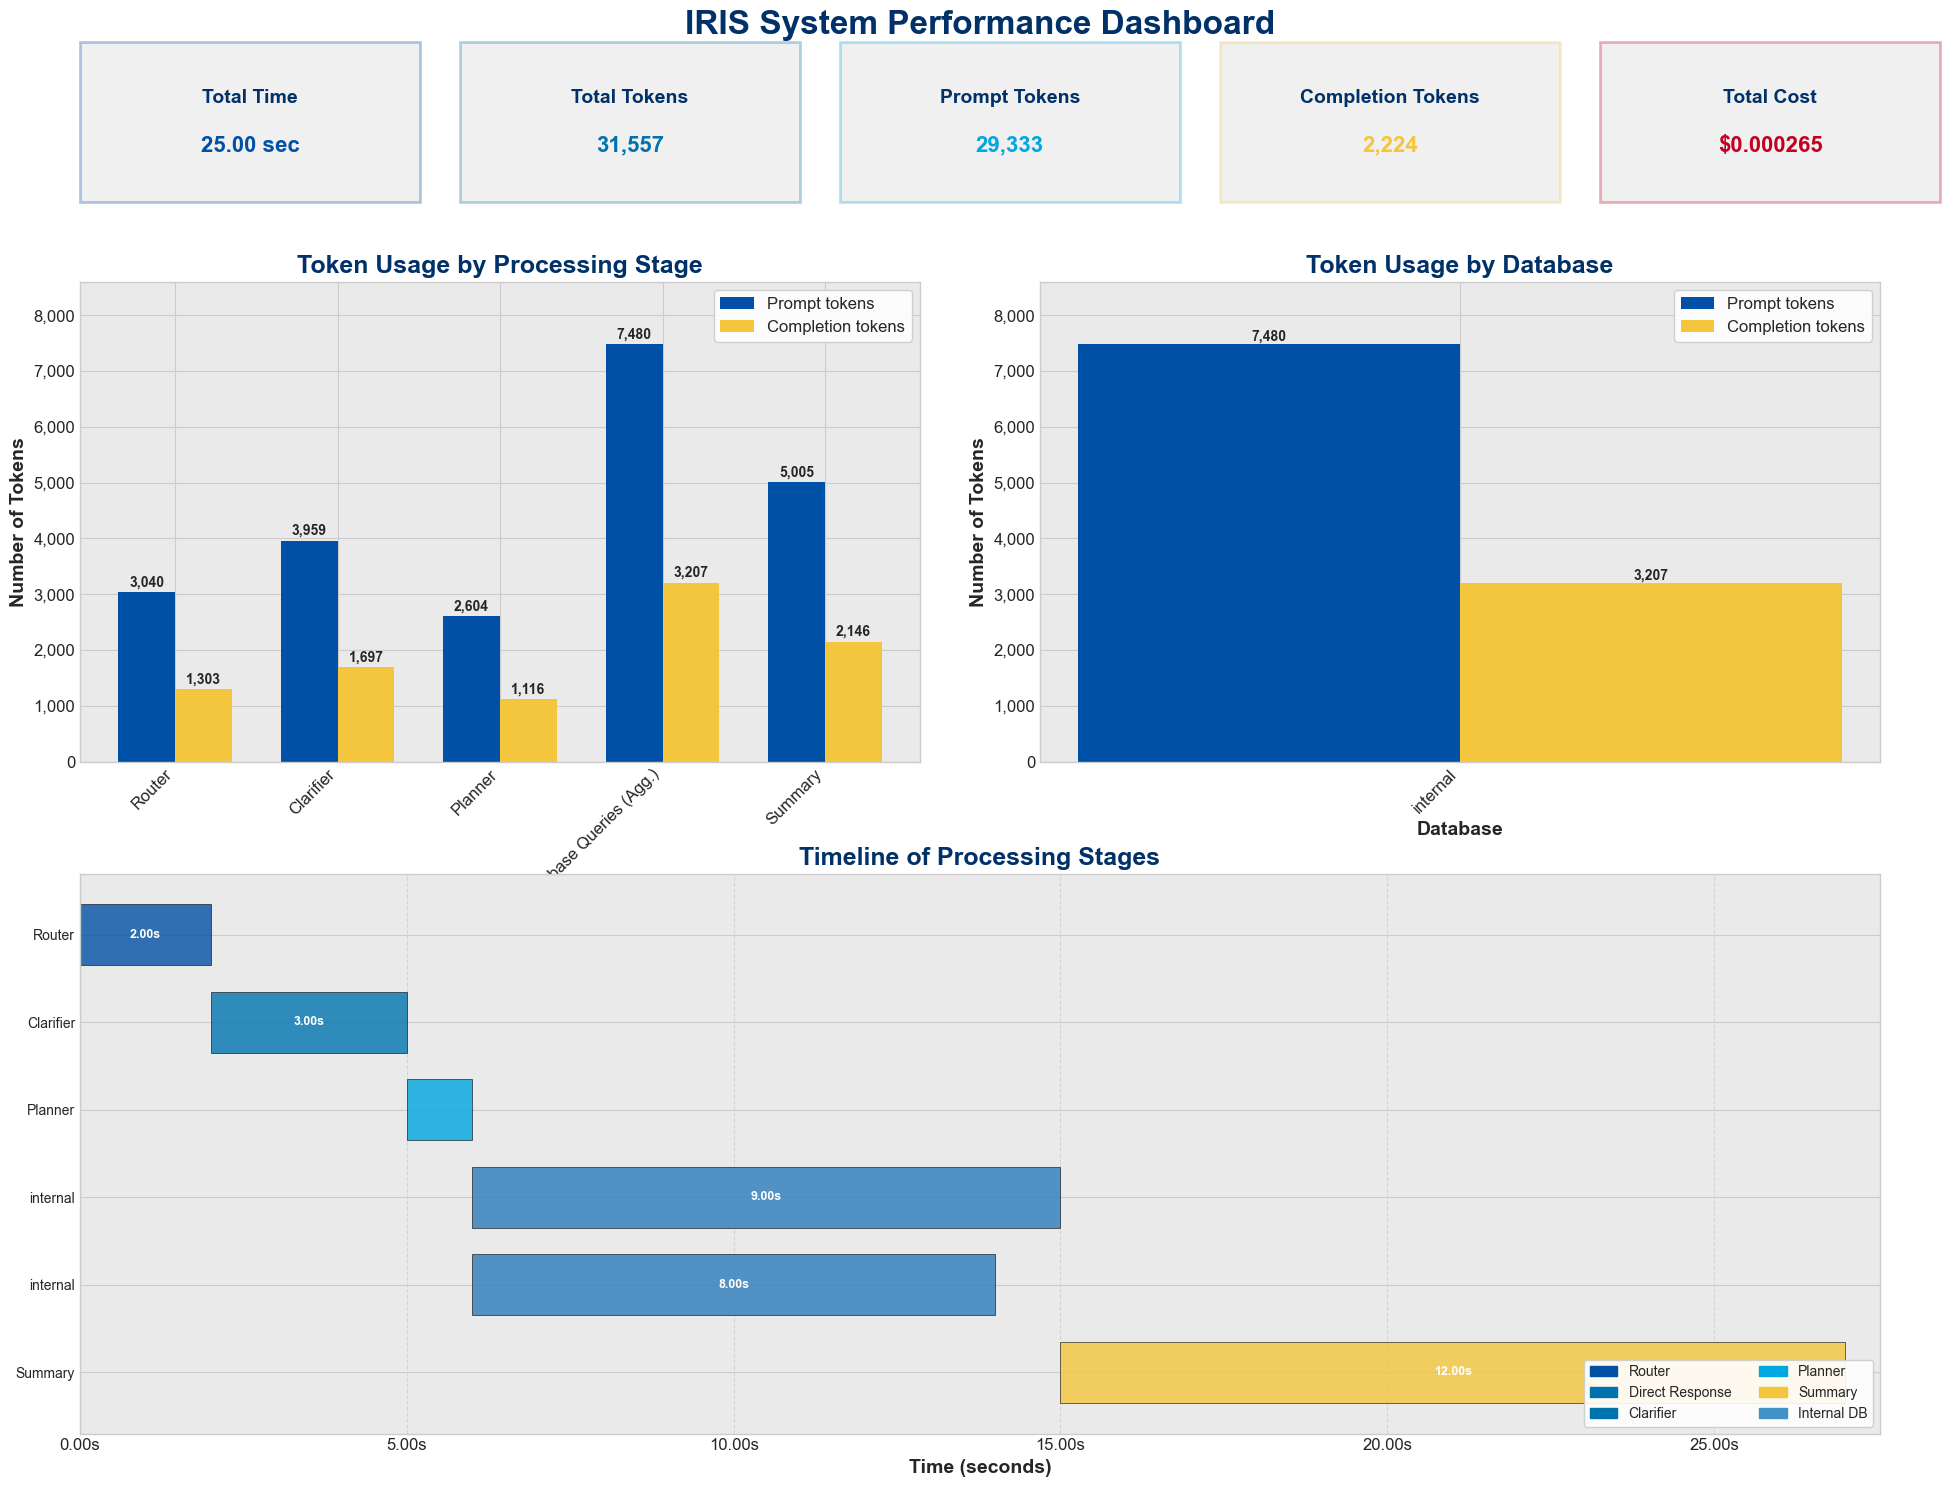

In [4]:
# Set up a widescreen dashboard visualization for process analytics and token usage
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors  # Add this import for rgb2hex
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import re
import json

# RBC color theme
rbc_colors = {
    'primary_blue': '#0051A5',  # RBC Royal Blue
    'secondary_blue': '#0073AE', # RBC Secondary Blue
    'accent_blue': '#00A7E1',   # RBC Light Blue
    'dark_blue': '#003168',     # RBC Dark Blue
    'gold': '#F4C63D',          # RBC Gold
    'navy': '#14133B',          # RBC Navy
    'red': '#C40022',           # RBC Red
    'light_gray': '#EAEAEA',    # Light Gray for backgrounds
    'medium_gray': '#D0D0D0'    # Medium Gray for tile backgrounds
}

# Set the matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')

# Parse the process monitor data or use legacy data
if process_monitor_output:
    # Extract stages information from the monitoring output
    stages_data = []
    
    # Parse the monitoring output
    # Extract overall stats
    total_duration_match = re.search(r'Total Duration: (\d+\.\d+) seconds', process_monitor_output)
    total_duration = float(total_duration_match.group(1)) if total_duration_match else 25.0
    
    prompt_tokens_match = re.search(r'Prompt Tokens: (\d+)', process_monitor_output)
    prompt_tokens = int(prompt_tokens_match.group(1)) if prompt_tokens_match else 0
    
    completion_tokens_match = re.search(r'Completion Tokens: (\d+)', process_monitor_output)
    completion_tokens = int(completion_tokens_match.group(1)) if completion_tokens_match else 0
    
    total_tokens_match = re.search(r'Total Tokens: (\d+)', process_monitor_output)
    total_tokens = int(total_tokens_match.group(1)) if total_tokens_match else 0
    
    cost_match = re.search(r'Cost: \$(\d+\.\d+)', process_monitor_output)
    cost = float(cost_match.group(1)) if cost_match else 0
    
    monitor_stats = {
        "total_duration": total_duration,
        "prompt_tokens": prompt_tokens,
        "completion_tokens": completion_tokens,
        "total_tokens": total_tokens,
        "cost": cost,
    }
    
    # Extract individual stages
    stage_pattern = r'([✅|❌|⏳]) \*\*([^*]+)\*\*\n(.*?)(?=(?:[✅|❌|⏳]) \*\*|$)'
    stage_matches = re.finditer(stage_pattern, process_monitor_output, re.DOTALL)
    
    for match in stage_matches:
        status_icon = match.group(1)
        stage_name = match.group(2).strip()
        stage_details = match.group(3).strip()
        status = "completed" if status_icon == "✅" else "error" if status_icon == "❌" else "in_progress"
        start_time_match = re.search(r'Start: (\d{2}:\d{2}:\d{2})', stage_details)
        start_time = start_time_match.group(1) if start_time_match else None
        end_time_match = re.search(r'End: (\d{2}:\d{2}:\d{2})', stage_details)
        end_time = end_time_match.group(1) if end_time_match else None
        duration_match = re.search(r'Duration: (\d+\.\d+) seconds', stage_details)
        duration = float(duration_match.group(1)) if duration_match else None
        tokens_match = re.search(r'Tokens: (\d+) \(Cost: \$(\d+\.\d+)\)', stage_details)
        tokens = int(tokens_match.group(1)) if tokens_match else 0
        token_cost = float(tokens_match.group(2)) if tokens_match else 0
        
        if tokens > 0:
            prompt_tokens_stage = int(tokens * 0.7)
            completion_tokens_stage = tokens - prompt_tokens_stage
        else:
            prompt_tokens_stage = 0
            completion_tokens_stage = 0
            
        details = {}
        detail_matches = re.finditer(r'- ([^:]+): (.+)', stage_details)
        for detail_match in detail_matches:
            key = detail_match.group(1).strip()
            value = detail_match.group(2).strip()
            details[key] = value
            
        if start_time:
            stages_data.append({
                'stage': stage_name,
                'status': status,
                'start_time': start_time,
                'end_time': end_time if end_time else start_time,
                'duration': duration if duration else 0,
                'prompt_tokens': prompt_tokens_stage,
                'completion_tokens': completion_tokens_stage,
                'total_tokens': tokens,
                'cost': token_cost,
                'details': details
            })
            
    df_stages = pd.DataFrame(stages_data)
    
    # --- Helper function to clean DB names --- 
    def clean_db_name(stage_name):
        if stage_name.startswith('db_query_'):
            parts = stage_name.split('_')
            if len(parts) > 2:
                db_part = parts[2]
                # Remove prefixes
                if db_part.startswith('internal_'):
                    return db_part[len('internal_'):]
                elif db_part.startswith('external_'):
                    return db_part[len('external_'):]
                else:
                    return db_part
            else:
                return "Unknown DB"
        return stage_name # Return original if not a db query
        
    # Identify database query stages
    db_query_stages = df_stages[df_stages['stage'].str.startswith('db_query_')].copy()
    
    # Create a dataframe for database summary (for token chart)
    if not db_query_stages.empty:
        db_query_stages['database'] = db_query_stages['stage'].apply(clean_db_name)
        db_query_stages['query_index'] = db_query_stages['stage'].apply(
            lambda x: x.split('_')[3] if len(x.split('_')) > 3 else '1'
        )
        # Group by the *cleaned* database name for the token chart
        db_summary = db_query_stages.groupby('database').agg({
            'prompt_tokens': 'sum',
            'completion_tokens': 'sum',
            'total_tokens': 'sum',
            'cost': 'sum',
            'duration': 'sum' # Sum duration if needed, though maybe less meaningful when grouped
        }).reset_index()
        db_summary['display_name'] = db_summary['database'] # Use cleaned name for display
    else:
        db_summary = pd.DataFrame(columns=['database', 'display_name', 'prompt_tokens', 
                                         'completion_tokens', 'total_tokens', 'cost', 'duration'])
    
    # Create normal stages summary (aggregating all db_query stages for token chart)
    normal_stages_summary = []
    stage_categories = {
        'router': ['router'],
        'direct_response': ['direct_response'],
        'clarifier': ['clarifier'],
        'planner': ['planner'],
        'database_query': [s for s in df_stages['stage'] if s.startswith('db_query_')],
        'summary': ['summary']
    }
    
    # Categorize stages (excluding setup)
    processed_for_summary = set(['ssl_setup', 'oauth_setup', 'conversation_processing'])
    for stage_name in df_stages['stage'].unique():
        if stage_name in processed_for_summary:
            continue
        categorized = False
        for category, stage_list in stage_categories.items():
            if stage_name in stage_list or (category == 'database_query' and stage_name.startswith('db_query_')):
                 # Add to summary if it belongs to a defined category
                 category_stages = df_stages[df_stages['stage'] == stage_name]
                 if category == 'database_query': # Aggregate all DB queries under one category for this chart
                     db_cat_summary = next((item for item in normal_stages_summary if item['stage'] == 'database_query'), None)
                     if db_cat_summary:
                         db_cat_summary['prompt_tokens'] += category_stages['prompt_tokens'].sum()
                         db_cat_summary['completion_tokens'] += category_stages['completion_tokens'].sum()
                         db_cat_summary['total_tokens'] += category_stages['total_tokens'].sum()
                         db_cat_summary['cost'] += category_stages['cost'].sum()
                         db_cat_summary['duration'] += category_stages['duration'].sum()
                     else:
                         normal_stages_summary.append({
                             'stage': 'database_query',
                             'prompt_tokens': category_stages['prompt_tokens'].sum(),
                             'completion_tokens': category_stages['completion_tokens'].sum(),
                             'total_tokens': category_stages['total_tokens'].sum(),
                             'cost': category_stages['cost'].sum(),
                             'duration': category_stages['duration'].sum()
                         })
                 elif not any(item['stage'] == category for item in normal_stages_summary):
                     # Add non-DB categories only once
                     normal_stages_summary.append({
                         'stage': category,
                         'prompt_tokens': category_stages['prompt_tokens'].sum(),
                         'completion_tokens': category_stages['completion_tokens'].sum(),
                         'total_tokens': category_stages['total_tokens'].sum(),
                         'cost': category_stages['cost'].sum(),
                         'duration': category_stages['duration'].sum()
                     })
                 processed_for_summary.add(stage_name)
                 categorized = True
                 break
        if not categorized:
             # Handle uncategorized stages if necessary (e.g., add as 'other')
             print(f"Warning: Uncategorized stage '{stage_name}' found.")
             processed_for_summary.add(stage_name)
             
    df_normal_stages = pd.DataFrame(normal_stages_summary)
    
    # Define order and display names for the STAGE token chart
    stage_token_chart_order = [
        'router',
        'direct_response',
        'clarifier',
        'planner',
        'database_query', # Represents aggregated DB queries here
        'summary'
    ]
    stage_display_names = {
        'router': 'Router',
        'direct_response': 'Direct Response',
        'clarifier': 'Clarifier',
        'planner': 'Planner',
        'database_query': 'Database Queries (Agg.)',
        'summary': 'Summary'
    }
    
    # Add display names and order to stage token dataframe
    df_normal_stages['display_name'] = df_normal_stages['stage'].map(
        lambda s: stage_display_names.get(s, s.replace('_', ' ').title())
    )
    known_stages_token_chart = {s: i for i, s in enumerate(stage_token_chart_order)}
    df_normal_stages['stage_order'] = df_normal_stages['stage'].apply(
        lambda s: known_stages_token_chart.get(s, 999)
    )
    df_normal_stages = df_normal_stages.sort_values('stage_order')
    
    # --- Timeline Data Preparation ---
    first_time = None
    timeline_data = []
    for _, row in df_stages.iterrows():
        if row['stage'] in ['ssl_setup', 'oauth_setup', 'conversation_processing']:
            continue
        if row['start_time'] and row['end_time']:
            try:
                start_dt = datetime.strptime(f"{datetime.now().date()} {row['start_time']}", "%Y-%m-%d %H:%M:%S")
                end_dt = datetime.strptime(f"{datetime.now().date()} {row['end_time']}", "%Y-%m-%d %H:%M:%S")
                if end_dt < start_dt: # Handle day rollover
                    end_dt = end_dt + pd.Timedelta(days=1)
                if first_time is None: first_time = start_dt
                start_seconds = (start_dt - first_time).total_seconds()
                end_seconds = (end_dt - first_time).total_seconds()
                timeline_data.append({
                    'stage': row['stage'],
                    'start_seconds': start_seconds,
                    'end_seconds': end_seconds,
                    'duration': max(0.01, end_seconds - start_seconds) # Ensure non-zero duration for visibility
                })
            except (ValueError, TypeError) as e:
                print(f"Error processing timeline data for {row['stage']}: {e}")
                
    df_timeline = pd.DataFrame(timeline_data)
    df_timeline = df_timeline.sort_values('start_seconds')
    
    # --- Timeline Labeling and Ordering --- 
    # Function to get display name for timeline (handles DB queries differently)
    def get_timeline_display_stage(stage_name):
        if stage_name.startswith('db_query_'):
            cleaned_name = clean_db_name(stage_name)
            query_idx = stage_name.split('_')[3] if len(stage_name.split('_')) > 3 else '1'
            # Keep query index for timeline uniqueness if needed, or remove for cleaner look
            # return f"{cleaned_name} (Q{query_idx})" 
            return cleaned_name # Just the cleaned DB name
        else:
            return stage_display_names.get(stage_name, stage_name.replace('_', ' ').title())
            
    df_timeline['display_stage'] = df_timeline['stage'].apply(get_timeline_display_stage)
    
    # Define the DESIRED vertical order for the timeline
    timeline_plot_order = [
        'router',
        'direct_response',
        'clarifier',
        'planner',
        'db_query', # Placeholder for all database queries
        'summary'
    ]
    
    # Define colors for stages
    stage_colors = {
        'Router': rbc_colors['primary_blue'],
        'Direct Response': rbc_colors['secondary_blue'],
        'Clarifier': rbc_colors['secondary_blue'], # Same as direct response? Choose another if needed
        'Planner': rbc_colors['accent_blue'],
        'Summary': rbc_colors['gold'],
        # Database colors will be assigned dynamically
    }
    internal_cmap = plt.cm.Blues(np.linspace(0.4, 0.8, 10))
    external_cmap = plt.cm.Oranges(np.linspace(0.4, 0.8, 10))
    db_color_map = {}
    
    # --- Create the Dashboard --- 
    fig = plt.figure(figsize=(20, 16))
    stat_tiles = [
        {"title": "Total Time", "value": f"{monitor_stats['total_duration']:.2f} sec", "color": rbc_colors['primary_blue']},
        {"title": "Total Tokens", "value": f"{monitor_stats['total_tokens']:,}", "color": rbc_colors['secondary_blue']},
        {"title": "Prompt Tokens", "value": f"{monitor_stats['prompt_tokens']:,}", "color": rbc_colors['accent_blue']},
        {"title": "Completion Tokens", "value": f"{monitor_stats['completion_tokens']:,}", "color": rbc_colors['gold']},
        {"title": "Total Cost", "value": f"${monitor_stats['cost']:.6f}", "color": rbc_colors['red']}
    ]
    for i, stat in enumerate(stat_tiles):
        left, bottom, width, height = 0.05 + (i * 0.19), 0.85, 0.17, 0.10
        rect = patches.Rectangle((left, bottom), width, height, linewidth=2, edgecolor=stat["color"], facecolor=rbc_colors['medium_gray'], alpha=0.3)
        fig.add_artist(rect)
        fig.text(left + width/2, bottom + height*0.65, stat["title"], ha='center', va='center', fontsize=14, fontweight='bold', color=rbc_colors['dark_blue'])
        fig.text(left + width/2, bottom + height*0.35, stat["value"], ha='center', va='center', fontsize=16, fontweight='bold', color=stat["color"])
        
    ax_tokens = fig.add_axes([0.05, 0.5, 0.42, 0.3])
    ax_db = fig.add_axes([0.53, 0.5, 0.42, 0.3])
    ax_timeline = fig.add_axes([0.05, 0.08, 0.9, 0.35])
    fig.text(0.5, 0.96, 'IRIS System Performance Dashboard', ha='center', va='center', fontsize=24, fontweight='bold', color=rbc_colors['dark_blue'])
    
    # 1. Token Usage by Stage Chart
    if not df_normal_stages.empty:
        bar_width = 0.35
        x = np.arange(len(df_normal_stages))
        prompt_bars = ax_tokens.bar(x - bar_width/2, df_normal_stages['prompt_tokens'], bar_width, label='Prompt tokens', color=rbc_colors['primary_blue'])
        completion_bars = ax_tokens.bar(x + bar_width/2, df_normal_stages['completion_tokens'], bar_width, label='Completion tokens', color=rbc_colors['gold'])
        for bars in [prompt_bars, completion_bars]:
            for bar in bars:
                height = bar.get_height()
                if height > 0: ax_tokens.text(bar.get_x() + bar.get_width()/2., height + 50, f'{height:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        ax_tokens.set_xlabel('Processing Stage', fontsize=14, fontweight='bold')
        ax_tokens.set_ylabel('Number of Tokens', fontsize=14, fontweight='bold')
        ax_tokens.set_title('Token Usage by Processing Stage', fontsize=18, fontweight='bold', color=rbc_colors['dark_blue'])
        ax_tokens.set_xticks(x)
        ax_tokens.set_xticklabels(df_normal_stages['display_name'], rotation=45, ha='right', fontsize=12)
        ax_tokens.tick_params(axis='y', labelsize=12)
        ax_tokens.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        ax_tokens.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=12)
        ax_tokens.set_facecolor(rbc_colors['light_gray'])
        if len(df_normal_stages) > 0: y_top = max(df_normal_stages['prompt_tokens'].max(), df_normal_stages['completion_tokens'].max()) * 1.15
        else: y_top = 100
        ax_tokens.set_ylim(0, y_top if y_top > 0 else 100)
    else:
        ax_tokens.text(0.5, 0.5, "No stage data available", ha='center', va='center', fontsize=14, fontweight='bold', color=rbc_colors['dark_blue'])
        
    # 2. Token Usage by Database Chart (Using cleaned names)
    if not db_summary.empty:
        bar_width = 0.35
        x = np.arange(len(db_summary))
        prompt_bars = ax_db.bar(x - bar_width/2, db_summary['prompt_tokens'], bar_width, label='Prompt tokens', color=rbc_colors['primary_blue'])
        completion_bars = ax_db.bar(x + bar_width/2, db_summary['completion_tokens'], bar_width, label='Completion tokens', color=rbc_colors['gold'])
        for bars in [prompt_bars, completion_bars]:
            for bar in bars:
                height = bar.get_height()
                if height > 0: ax_db.text(bar.get_x() + bar.get_width()/2., height + 5, f'{height:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        ax_db.set_xlabel('Database', fontsize=14, fontweight='bold')
        ax_db.set_ylabel('Number of Tokens', fontsize=14, fontweight='bold')
        ax_db.set_title('Token Usage by Database', fontsize=18, fontweight='bold', color=rbc_colors['dark_blue'])
        ax_db.set_xticks(x)
        # Use the cleaned 'display_name' from db_summary
        ax_db.set_xticklabels(db_summary['display_name'], rotation=45, ha='right', fontsize=12)
        ax_db.tick_params(axis='y', labelsize=12)
        ax_db.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        ax_db.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=12)
        ax_db.set_facecolor(rbc_colors['light_gray'])
        if len(db_summary) > 0: y_top = max(db_summary['prompt_tokens'].max(), db_summary['completion_tokens'].max()) * 1.15
        else: y_top = 100
        ax_db.set_ylim(0, y_top if y_top > 0 else 100)
    else:
        ax_db.text(0.5, 0.5, "No database query data available", ha='center', va='center', fontsize=14, fontweight='bold', color=rbc_colors['dark_blue'])
        
    # 3. Timeline Visualization (Ordered and Cleaned Labels)
    if not df_timeline.empty:
        # --- Calculate Stage Positions Based on Desired Order --- 
        stage_positions = {}
        y_labels = []
        y_ticks = []
        current_y = 0
        spacing = 1.0
        height = 0.7
        
        # Get unique database stages present in the data, sorted alphabetically
        db_stages_present = sorted(df_timeline[df_timeline['stage'].str.startswith('db_query_')]['stage'].unique())
        
        # Iterate through the desired plot order
        for order_item in timeline_plot_order:
            if order_item == 'db_query':
                # Add all present database stages here
                for db_stage_name in db_stages_present:
                    if db_stage_name not in stage_positions:
                        stage_positions[db_stage_name] = current_y
                        y_labels.append(get_timeline_display_stage(db_stage_name))
                        y_ticks.append(current_y)
                        current_y += spacing
            else:
                # Add non-database stages if present
                if order_item in df_timeline['stage'].values and order_item not in stage_positions:
                    stage_positions[order_item] = current_y
                    y_labels.append(get_timeline_display_stage(order_item))
                    y_ticks.append(current_y)
                    current_y += spacing
                    
        # Add any other stages not in the defined order at the end (optional)
        # for stage_name in df_timeline['stage'].unique():
        #     if stage_name not in stage_positions:
        #         stage_positions[stage_name] = current_y
        #         y_labels.append(get_timeline_display_stage(stage_name))
        #         y_ticks.append(current_y)
        #         current_y += spacing
        # --- Plotting --- 
        for _, row in df_timeline.iterrows():
            stage = row['stage']
            display_stage = row['display_stage'] # Cleaned name
            
            # Get color
            color = 'gray' # Default
            if stage.startswith('db_query_'):
                if display_stage not in db_color_map:
                    # Assign color based on original name (internal/external)
                    is_external = 'external' in stage
                    cmap = external_cmap if is_external else internal_cmap
                    idx = hash(display_stage) % len(cmap)
                    db_color_map[display_stage] = mcolors.rgb2hex(cmap[idx])
                color = db_color_map[display_stage]
            else:
                color = stage_colors.get(display_stage, 'gray')
                
            # Get position
            if stage in stage_positions:
                position = stage_positions[stage]
                ax_timeline.barh(position, row['duration'], left=row['start_seconds'], height=height, color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
                # Add text label inside bar if wide enough
                if row['duration'] > total_duration * 0.05: # Adjust threshold as needed
                     ax_timeline.text(row['start_seconds'] + row['duration']/2, position, f"{row['duration']:.2f}s", 
                                      ha='center', va='center', color='white', fontweight='bold', fontsize=9)
            else:
                 print(f"Warning: Stage '{stage}' not found in calculated positions.")
                 
        # Configure timeline axes
        ax_timeline.set_yticks(y_ticks)
        ax_timeline.set_yticklabels(y_labels, fontsize=10)
        ax_timeline.set_xlabel('Time (seconds)', fontsize=14, fontweight='bold')
        ax_timeline.set_title('Timeline of Processing Stages', fontsize=18, fontweight='bold', color=rbc_colors['dark_blue'])
        ax_timeline.tick_params(axis='x', labelsize=12)
        ax_timeline.grid(axis='x', linestyle='--', alpha=0.7)
        ax_timeline.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}s'))
        ax_timeline.set_facecolor(rbc_colors['light_gray'])
        total_time = df_timeline['end_seconds'].max() if len(df_timeline) > 0 else 1
        ax_timeline.set_xlim(0, total_time * 1.02)
        ax_timeline.set_ylim(-height, max(y_ticks) + height if y_ticks else height) # Adjust ylim based on actual ticks
        ax_timeline.invert_yaxis() # Show Router at the top
        
        # Create custom legend
        legend_items = []
        added_labels = set()
        # Add main stages first
        for stage_key in timeline_plot_order:
             display_name = stage_display_names.get(stage_key)
             if display_name and display_name in stage_colors and display_name not in added_labels:
                 legend_items.append(patches.Patch(color=stage_colors[display_name], label=display_name))
                 added_labels.add(display_name)
        # Add database types
        if any('internal' in s for s in db_stages_present):
             legend_items.append(patches.Patch(color=mcolors.rgb2hex(internal_cmap[5]), label='Internal DB'))
        if any('external' in s for s in db_stages_present):
             legend_items.append(patches.Patch(color=mcolors.rgb2hex(external_cmap[5]), label='External DB'))
             
        ax_timeline.legend(handles=legend_items, loc='lower right', fontsize=10, frameon=True, framealpha=0.9, ncol=2)
    else:
        ax_timeline.text(0.5, 0.5, "No timeline data available", ha='center', va='center', fontsize=14, fontweight='bold', color=rbc_colors['dark_blue'])
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap
    plt.show()
    
# Fall back to legacy debug data if no process monitor output is available
elif debug_data:
    # --- Legacy Data Handling (Keep original logic or adapt similarly) ---
    # NOTE: The legacy data handling part is kept mostly as-is.
    # You might want to apply similar cleaning/ordering logic here if needed.
    decisions_sorted = sorted(debug_data['decisions'], key=lambda x: datetime.fromisoformat(x['timestamp']))
    stage_order_legacy = [
        'router', 'clarifier', 'planner', 'database_query', 'judge', 'summary'
    ]
    stage_display_names_legacy = {
        'router': 'Router', 'clarifier': 'Clarifier', 'planner': 'Planner',
        'database_query': 'Database Query', 'judge': 'Judge', 'summary': 'Summary'
    }
    overall_start = datetime.fromisoformat(debug_data['start_timestamp'])
    overall_end = datetime.fromisoformat(debug_data['end_timestamp'])
    total_duration = (overall_end - overall_start).total_seconds()
    stages_data_legacy = []
    for decision in decisions_sorted:
        stage = decision['stage']
        timestamp = datetime.fromisoformat(decision['timestamp'])
        if 'token_usage' in decision:
            token_usage = decision['token_usage']
            stages_data_legacy.append({
                'stage': stage,
                'display_name': stage_display_names_legacy.get(stage, stage),
                'timestamp': timestamp,
                'prompt_tokens': token_usage.get('prompt_tokens', 0),
                'completion_tokens': token_usage.get('completion_tokens', 0),
                'total_tokens': token_usage.get('total_tokens', 0),
                'cost': token_usage.get('cost', 0.0)
            })
    df_stages_legacy = pd.DataFrame(stages_data_legacy)
    df_stages_legacy['time_seconds'] = (df_stages_legacy['timestamp'] - overall_start).dt.total_seconds()
    stage_totals_legacy = df_stages_legacy.groupby(['stage', 'display_name']).agg({
        'prompt_tokens': 'sum', 'completion_tokens': 'sum', 'total_tokens': 'sum', 'cost': 'sum'
    }).reset_index()
    stage_totals_legacy['stage_order'] = stage_totals_legacy['stage'].map({s: i for i, s in enumerate(stage_order_legacy)})
    stage_totals_legacy = stage_totals_legacy.sort_values('stage_order')
    db_data_legacy = []
    if debug_data['tokens'].get('databases'):
        for db_name, usage in debug_data['tokens']['databases'].items():
            # Apply cleaning here if desired for legacy DB chart
            cleaned_db_name_legacy = clean_db_name(f"db_query_{db_name}") # Reuse cleaning function
            db_data_legacy.append({
                'database': cleaned_db_name_legacy, # Use cleaned name
                'display_name': cleaned_db_name_legacy, # Use cleaned name
                'prompt_tokens': usage.get('prompt_tokens', 0),
                'completion_tokens': usage.get('completion_tokens', 0),
                'total_tokens': usage.get('total_tokens', 0),
                'cost': usage.get('cost', 0.0)
            })
    df_db_legacy = pd.DataFrame(db_data_legacy)
    # Group again if cleaning resulted in duplicates
    if not df_db_legacy.empty:
         df_db_legacy = df_db_legacy.groupby('database').agg({
             'display_name': 'first', # Keep the first display name (should be same)
             'prompt_tokens': 'sum',
             'completion_tokens': 'sum',
             'total_tokens': 'sum',
             'cost': 'sum'
         }).reset_index()
         
    stage_colors_legacy = {
        'Router': rbc_colors['primary_blue'], 'Clarifier': rbc_colors['secondary_blue'],
        'Planner': rbc_colors['accent_blue'], 'Database Query': rbc_colors['navy'],
        'Judge': rbc_colors['gold'], 'Summary': rbc_colors['red']
    }
    fig_legacy = plt.figure(figsize=(20, 16))
    stat_tiles_legacy = [
        {"title": "Total Time", "value": f"{total_duration:.2f} sec", "color": rbc_colors['primary_blue']},
        {"title": "Total Tokens", "value": f"{debug_data['tokens']['total']:,}", "color": rbc_colors['secondary_blue']},
        {"title": "Prompt Tokens", "value": f"{debug_data['tokens']['prompt']:,}", "color": rbc_colors['accent_blue']},
        {"title": "Completion Tokens", "value": f"{debug_data['tokens']['completion']:,}", "color": rbc_colors['gold']},
        {"title": "Total Cost", "value": f"${debug_data['cost']:.6f}", "color": rbc_colors['red']}
    ]
    for i, stat in enumerate(stat_tiles_legacy):
        left, bottom, width, height = 0.05 + (i * 0.19), 0.85, 0.17, 0.10
        rect = patches.Rectangle((left, bottom), width, height, linewidth=2, edgecolor=stat["color"], facecolor=rbc_colors['medium_gray'], alpha=0.3)
        fig_legacy.add_artist(rect)
        fig_legacy.text(left + width/2, bottom + height*0.65, stat["title"], ha='center', va='center', fontsize=14, fontweight='bold', color=rbc_colors['dark_blue'])
        fig_legacy.text(left + width/2, bottom + height*0.35, stat["value"], ha='center', va='center', fontsize=16, fontweight='bold', color=stat["color"])
        
    ax_tokens_legacy = fig_legacy.add_axes([0.05, 0.5, 0.42, 0.3])
    ax_db_legacy = fig_legacy.add_axes([0.53, 0.5, 0.42, 0.3])
    ax_timeline_legacy = fig_legacy.add_axes([0.05, 0.08, 0.9, 0.35])
    fig_legacy.text(0.5, 0.96, 'IRIS System Performance Dashboard (Legacy Data)', ha='center', va='center', fontsize=24, fontweight='bold', color=rbc_colors['dark_blue'])
    
    # Legacy Token Chart
    bar_width = 0.35
    x = np.arange(len(stage_totals_legacy))
    prompt_bars = ax_tokens_legacy.bar(x - bar_width/2, stage_totals_legacy['prompt_tokens'], bar_width, label='Prompt tokens', color=rbc_colors['primary_blue'])
    completion_bars = ax_tokens_legacy.bar(x + bar_width/2, stage_totals_legacy['completion_tokens'], bar_width, label='Completion tokens', color=rbc_colors['gold'])
    for bars in [prompt_bars, completion_bars]:
        for bar in bars:
            height = bar.get_height()
            if height > 0: ax_tokens_legacy.text(bar.get_x() + bar.get_width()/2., height + 50, f'{height:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    ax_tokens_legacy.set_xlabel('Processing Stage', fontsize=14, fontweight='bold')
    ax_tokens_legacy.set_ylabel('Number of Tokens', fontsize=14, fontweight='bold')
    ax_tokens_legacy.set_title('Token Usage by Processing Stage', fontsize=18, fontweight='bold', color=rbc_colors['dark_blue'])
    ax_tokens_legacy.set_xticks(x)
    ax_tokens_legacy.set_xticklabels(stage_totals_legacy['display_name'], rotation=45, ha='right', fontsize=12)
    ax_tokens_legacy.tick_params(axis='y', labelsize=12)
    ax_tokens_legacy.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax_tokens_legacy.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=12)
    ax_tokens_legacy.set_facecolor(rbc_colors['light_gray'])
    if len(stage_totals_legacy) > 0: y_top = max(stage_totals_legacy['prompt_tokens'].max(), stage_totals_legacy['completion_tokens'].max()) * 1.15
    else: y_top = 100
    ax_tokens_legacy.set_ylim(0, y_top if y_top > 0 else 100)
    
    # Legacy DB Chart
    if not df_db_legacy.empty:
        x = np.arange(len(df_db_legacy))
        prompt_bars = ax_db_legacy.bar(x - bar_width/2, df_db_legacy['prompt_tokens'], bar_width, label='Prompt tokens', color=rbc_colors['primary_blue'])
        completion_bars = ax_db_legacy.bar(x + bar_width/2, df_db_legacy['completion_tokens'], bar_width, label='Completion tokens', color=rbc_colors['gold'])
        for bars in [prompt_bars, completion_bars]:
            for bar in bars:
                height = bar.get_height()
                if height > 0: ax_db_legacy.text(bar.get_x() + bar.get_width()/2., height + 5, f'{height:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        ax_db_legacy.set_xlabel('Database', fontsize=14, fontweight='bold')
        ax_db_legacy.set_ylabel('Number of Tokens', fontsize=14, fontweight='bold')
        ax_db_legacy.set_title('Token Usage by Database', fontsize=18, fontweight='bold', color=rbc_colors['dark_blue'])
        ax_db_legacy.set_xticks(x)
        ax_db_legacy.set_xticklabels(df_db_legacy['display_name'], rotation=45, ha='right', fontsize=12)
        ax_db_legacy.tick_params(axis='y', labelsize=12)
        ax_db_legacy.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        ax_db_legacy.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=12)
        ax_db_legacy.set_facecolor(rbc_colors['light_gray'])
        if len(df_db_legacy) > 0: y_top = max(df_db_legacy['prompt_tokens'].max(), df_db_legacy['completion_tokens'].max()) * 1.15
        else: y_top = 100
        ax_db_legacy.set_ylim(0, y_top if y_top > 0 else 100)
    else:
        ax_db_legacy.text(0.5, 0.5, "No database data available", ha='center', va='center', fontsize=14, fontweight='bold', color=rbc_colors['dark_blue'])
        
    # Legacy Timeline (Original logic - might need similar ordering adjustments)
    detailed_timeline_legacy = []
    for i, decision in enumerate(decisions_sorted):
        stage = decision['stage']
        timestamp = datetime.fromisoformat(decision['timestamp'])
        end_time = datetime.fromisoformat(decisions_sorted[i+1]['timestamp']) if i + 1 < len(decisions_sorted) else overall_end
        start_seconds = (timestamp - overall_start).total_seconds()
        end_seconds = (end_time - overall_start).total_seconds()
        duration = max(0.01, end_seconds - start_seconds)
        detailed_timeline_legacy.append({
            'stage': stage,
            'display_name': stage_display_names_legacy.get(stage, stage),
            'start_seconds': start_seconds,
            'end_seconds': end_seconds,
            'duration': duration
        })
    df_detailed_legacy = pd.DataFrame(detailed_timeline_legacy)
    df_detailed_legacy = df_detailed_legacy.sort_values('start_seconds')
    height_legacy = 0.8
    spacing_legacy = 1.5
    unique_stages_legacy = list(stage_display_names_legacy.keys())
    # Apply desired order here if needed for legacy timeline
    # Example: unique_stages_legacy = sorted(unique_stages_legacy, key=lambda s: stage_order_legacy.index(s) if s in stage_order_legacy else 999)
    stage_positions_legacy = {stage: i * spacing_legacy for i, stage in enumerate(reversed(unique_stages_legacy))}
    
    for _, row in df_detailed_legacy.iterrows():
        stage = row['stage']
        display_name = row['display_name']
        color = stage_colors_legacy.get(display_name, 'gray')
        if stage in stage_positions_legacy:
            position = stage_positions_legacy[stage]
            ax_timeline_legacy.barh(position, row['duration'], left=row['start_seconds'], height=height_legacy, color=color, alpha=0.8, edgecolor='black', linewidth=0.5)
            if row['duration'] > total_duration * 0.05:
                ax_timeline_legacy.text(row['start_seconds'] + row['duration']/2, position, f"{row['duration']:.2f}s", ha='center', va='center', color='white', fontweight='bold', fontsize=9)
        else:
             print(f"Warning: Legacy stage '{stage}' not found in positions.")
             
    positions_legacy = list(stage_positions_legacy.values())
    stage_names_legacy = [stage_display_names_legacy.get(s, s) for s in reversed(unique_stages_legacy)]
    ax_timeline_legacy.set_yticks(positions_legacy)
    ax_timeline_legacy.set_yticklabels(stage_names_legacy, fontsize=12)
    ax_timeline_legacy.set_xlabel('Time (seconds)', fontsize=14, fontweight='bold')
    ax_timeline_legacy.set_title('Timeline of Processing Stages', fontsize=18, fontweight='bold', color=rbc_colors['dark_blue'])
    ax_timeline_legacy.tick_params(axis='x', labelsize=12)
    ax_timeline_legacy.grid(axis='x', linestyle='--', alpha=0.7)
    ax_timeline_legacy.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}s'))
    ax_timeline_legacy.set_facecolor(rbc_colors['light_gray'])
    ax_timeline_legacy.set_xlim(0, total_duration * 1.02)
    ax_timeline_legacy.set_ylim(-height_legacy, max(positions_legacy) + height_legacy if positions_legacy else height_legacy)
    # ax_timeline_legacy.invert_yaxis() # Uncomment if you want Router at top for legacy too
    
    handles_legacy = [patches.Patch(color=color, label=name) for name, color in stage_colors_legacy.items()]
    ax_timeline_legacy.legend(handles=handles_legacy, loc='lower right', fontsize=12, frameon=True, framealpha=0.9, ncol=2)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("No debug data available. Make sure to run with debug_mode=True.")